In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
spark = SparkSession.builder.appName('SnowFallDecreasing').getOrCreate()

In [3]:
from io import StringIO
import itertools
import numpy as np
import pandas as pd
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(40,10))
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

<Figure size 2880x720 with 0 Axes>

In [4]:
%%time

def readFiles (feature):
    def process(tup):
        def convertTuple(tup): 
            str =  ''.join(tup) 
            return str

        # Driver code 
        str = convertTuple(tup[0:2]) 
        df = pd.read_csv(StringIO(str), header=None)

        # slicing the output and storing filename in "filename dataframe"
        filename = df[0:1]
        filename = filename.iloc[0][0].replace('txtncols         180','')
        filename = filename[-7:-1]

        # storing the content of file in "content dataframe"
        content = df[6:]

        counter = 0 
        allValues = 0
        
        # iterate through all the rows and columns of the file - better than for loop which took 40 mins
        modPandasDF=content.iloc[:,0].str.split(' ',expand=True).replace("-9999",float('NaN'))
        modPandasDF=modPandasDF.astype('float')
        modPandasDF=modPandasDF.values
        xDF=np.nanmean(modPandasDF)
        sum=np.nanmean(xDF)

        return filename, sum

    # daily grid data for rainfall
    if(feature=="rainfall" or feature=="maximum-temperature"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-daily/grid/"+feature+"/*"
    elif(feature=="sunshine" or feature=="snow-falling"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-monthly/"+feature+"/*"

    # Get rdd containing one record for each file.
    files_rdd = sc.wholeTextFiles(path, minPartitions=20)
    print(type(files_rdd))

    print('Number of records (months):', files_rdd.count())
    print('Number of partitions:', files_rdd.getNumPartitions())

    # map lines to n_words
    records = files_rdd.map(lambda n : process(n))

    # collect the RDD to a list
    llist = records.collect()

    # two arrays
    values = []
    months = []

    # store the filename in months array and its corrosponding value(mean) in values array
    for line in llist:
        values.append(line[1])
        months.append(line[0])

    # converting arrays to dataframes
    valuesdf = pd.DataFrame({'Days':values[:]})
    yearmonthdf = pd.DataFrame({'YearMonth':months[:]})

    # merging two dataframes into one
    finaldf = pd.merge(yearmonthdf, valuesdf, left_index=True, right_index=True)

    # sort the index
    finaldf = finaldf.sort_values('YearMonth')

    # converting first column to integer format
    finaldf['YearMonth'] = finaldf['YearMonth'].astype('int')

    # converting first column from integer to datetime format
    finaldf['YearMonth'] = pd.to_datetime(finaldf['YearMonth'].astype(str), format='%Y%m')

    # extracting year and month 
    finaldf['Year'] = finaldf['YearMonth'].dt.year
    finaldf['Month'] = finaldf['YearMonth'].dt.month

    print(finaldf.head())
    
    return finaldf

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


<class 'pyspark.rdd.RDD'>
Number of records (months): 492
Number of partitions: 20
     YearMonth      Days  Year  Month
175 1971-01-01  2.835985  1971      1
125 1971-02-01  3.918227  1971      2
300 1971-03-01  5.061826  1971      3
75  1971-04-01  1.100390  1971      4
325 1971-05-01  0.168767  1971      5


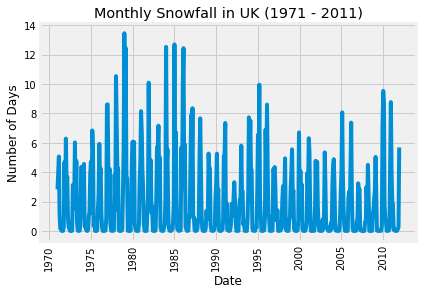

CPU times: user 200 ms, sys: 15 ms, total: 215 ms
Wall time: 7.71 s


In [5]:
%%time

finaldf = readFiles("snow-falling")

# general raw plot for a feature
plt.plot(finaldf.YearMonth, finaldf.Days)
plt.title('Monthly Snowfall in UK (1971 - 2011)')
plt.xlabel('Date')
plt.ylabel('Number of Days')
plt.xticks(rotation='vertical')
plt.show()

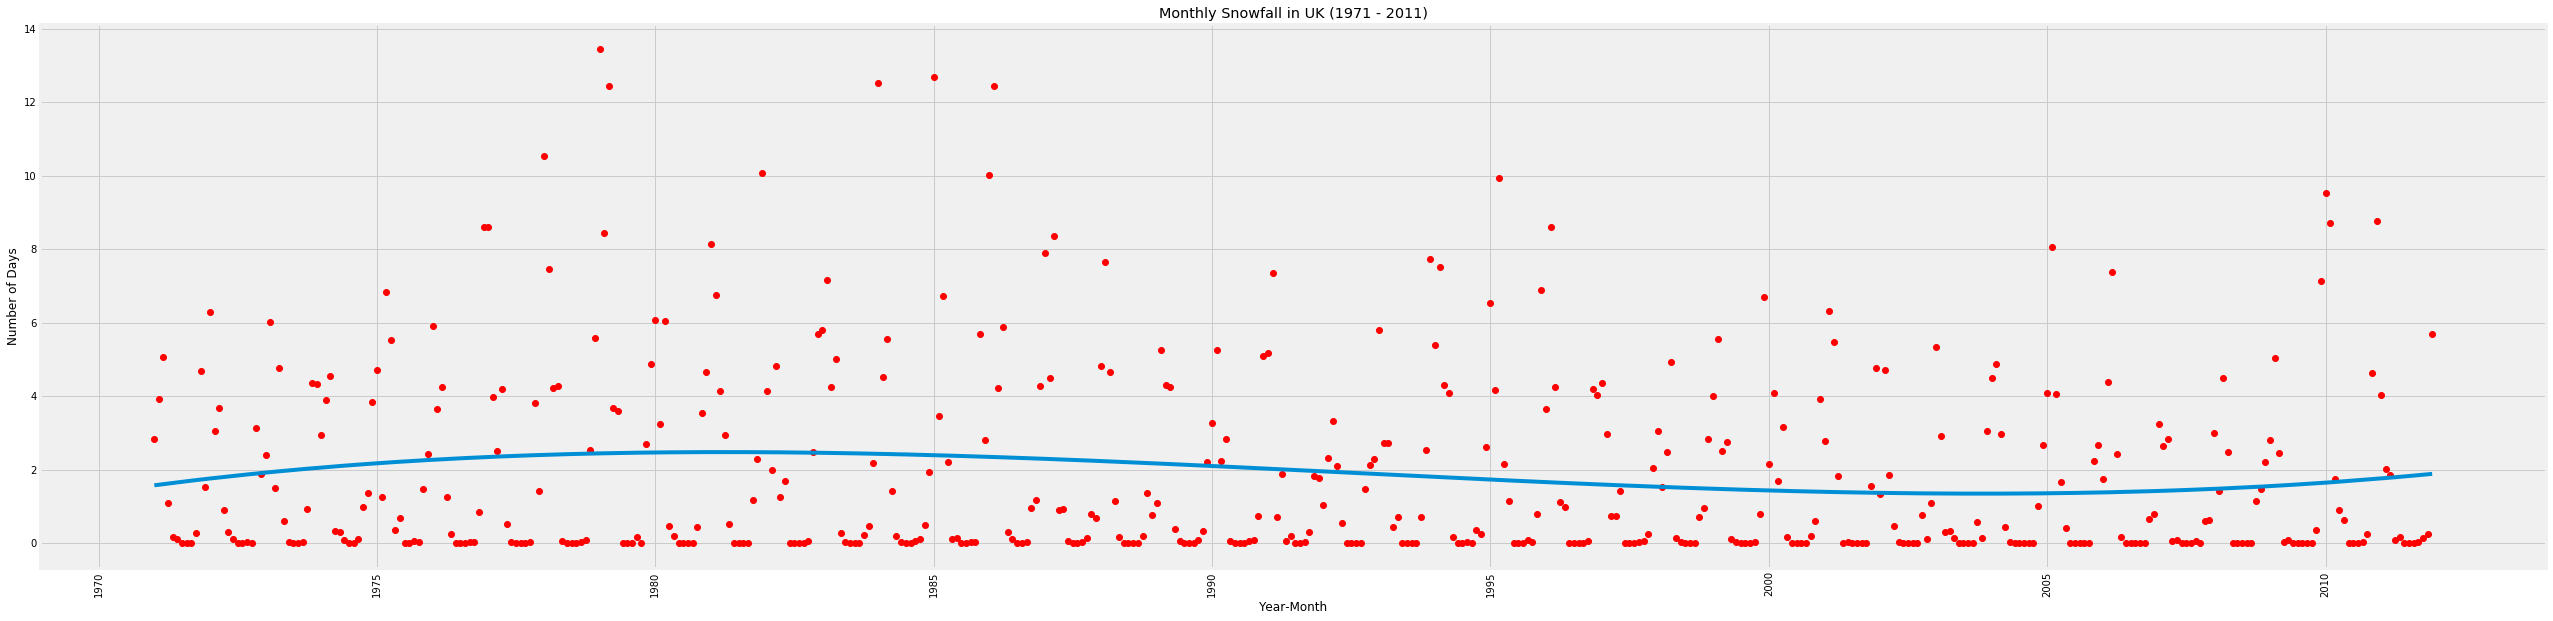

In [6]:
# BEST LINE FIT to look for any trend in data if present
y_values = finaldf['Days']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(finaldf.loc[:, "Days"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)
fig = plt.figure(figsize=(40,10))
plt.xlabel('Year-Month')
plt.title('Monthly Snowfall in UK (1971 - 2011)')
plt.ylabel('Number of Days')
plt.xticks(rotation='vertical')
plt.plot(finaldf.loc[:, "YearMonth"], finaldf.loc[:,"Days"], "ro")
plt.plot(finaldf.loc[:, "YearMonth"], y_hat)

In [7]:
finaldf.tail()

,YearMonth,Days,Year,Month
487,2011-08-01,0.000026,2011,8
488,2011-09-01,0.019241,2011,9
489,2011-10-01,0.127454,2011,10
490,2011-11-01,0.244415,2011,11
491,2011-12-01,5.677201,2011,12


In [8]:
# creating a backup(tempdf) of finaldf
tempdf = finaldf
tempdf.head()

,YearMonth,Days,Year,Month
175,1971-01-01,2.835985,1971,1
125,1971-02-01,3.918227,1971,2
300,1971-03-01,5.061826,1971,3
75,1971-04-01,1.100390,1971,4
325,1971-05-01,0.168767,1971,5


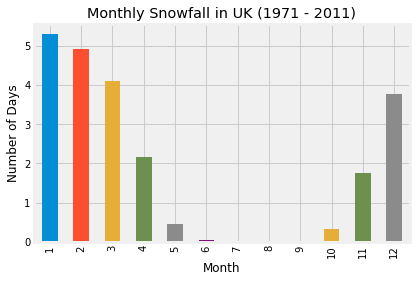

In [9]:
# plotting snowfall on monthly basis

snowfalldf = tempdf.loc[tempdf['Month'].isin(['1','2','3','4','5','6','7','8','9','10','11','12'])]
plt.xlabel('Months')
plt.title('Monthly Snowfall in UK (1971 - 2011)')
plt.ylabel('Number of Days')
snowfalldf.groupby('Month')['Days'].mean().plot.bar()

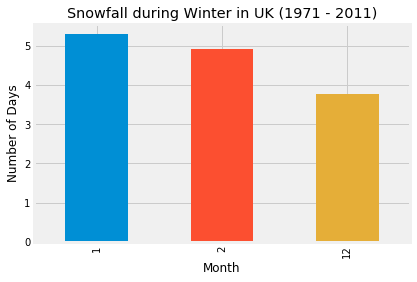

In [10]:
# plotting snowfall for months of winter (Jan=1, Feb=2, Dec=12)

snowfalldf = tempdf.loc[tempdf['Month'].isin(['1','2','12'])]
plt.xlabel('Months')
plt.title('Snowfall during Winter in UK (1971 - 2011)')
plt.ylabel('Number of Days')
snowfalldf.groupby('Month')['Days'].mean().plot.bar()

(array([1965., 1970., 1975., 1980., 1985., 1990., 1995., 2000., 2005.,
        2010., 2015.]), <a list of 11 Text xticklabel objects>)

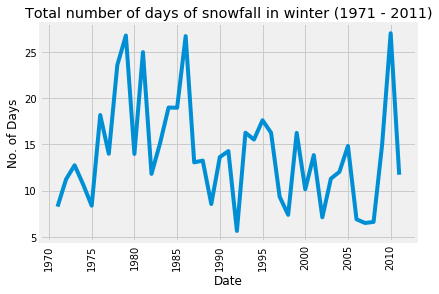

In [11]:
tempnewdf = snowfalldf.groupby(['Year'])['Days'].agg('sum').reset_index()
plt.plot(tempnewdf.Year, tempnewdf.Days)
plt.title('Total number of days of snowfall in winter (1971 - 2011)')
plt.xlabel('Date')
plt.ylabel('No. of Days')
plt.xticks(rotation='vertical') 

In [12]:
tempnewdf.head()

,Year,Days
0,1971,8.270093
1,1972,11.230994
2,1973,12.742278
3,1974,10.670488
4,1975,8.373998


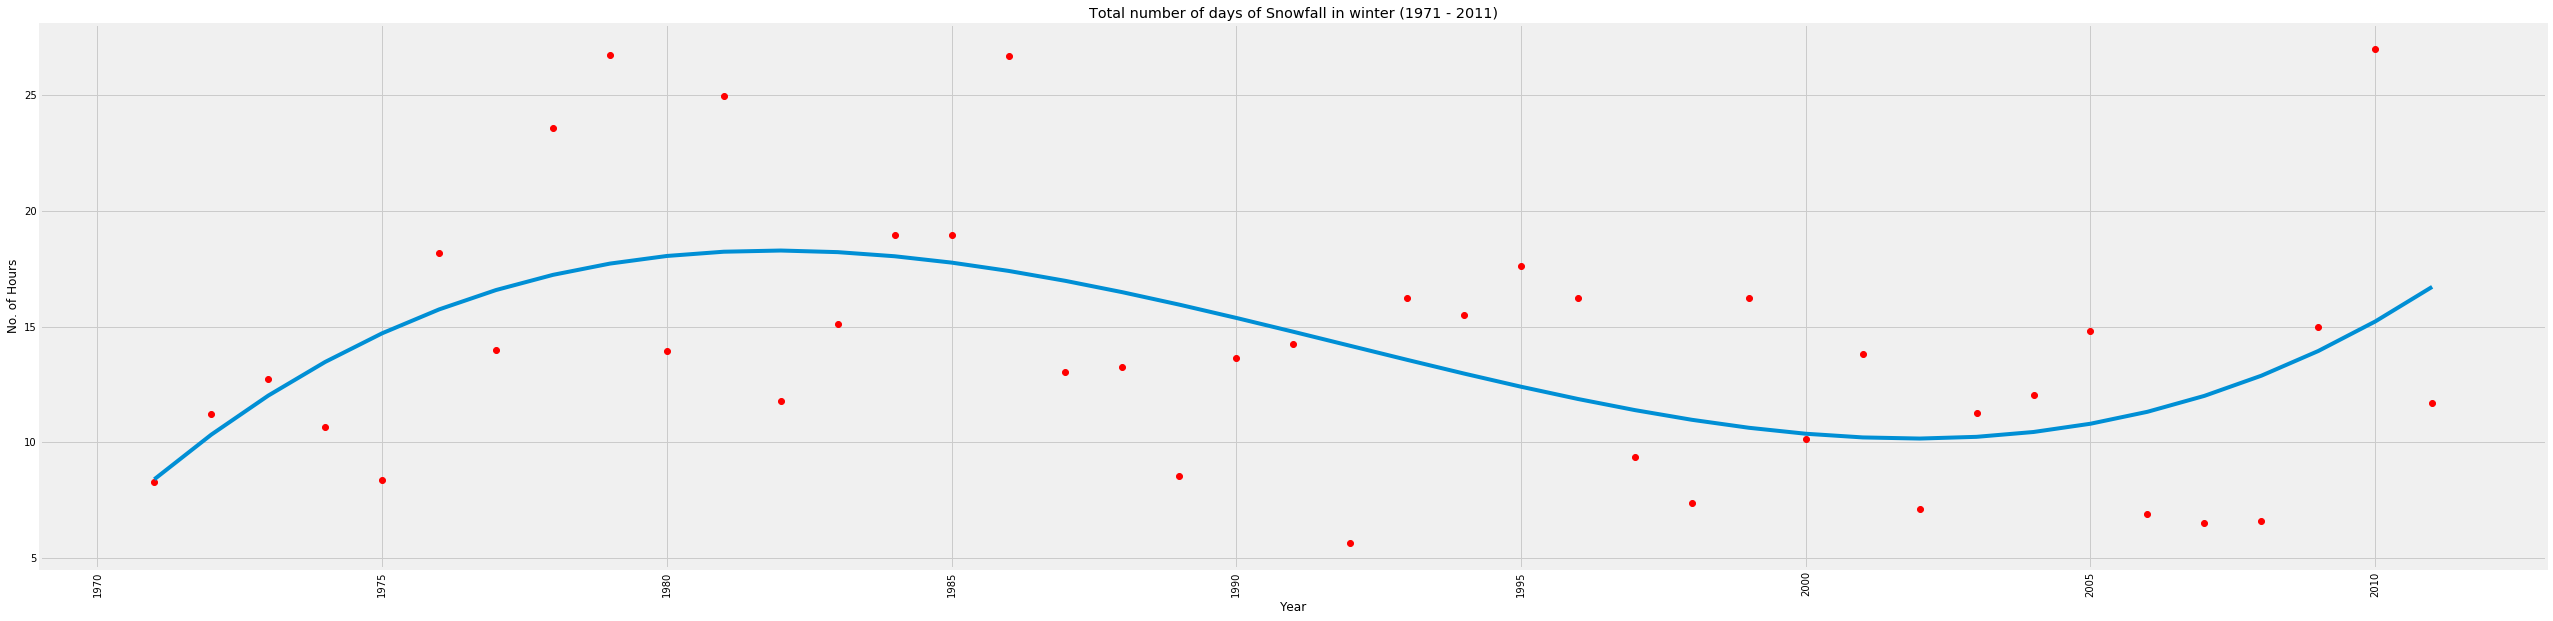

In [13]:
# BEST LINE FIT - the slope of this plot is better (increasing/decreasing) than the previous one
y_values = tempnewdf['Days']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(tempnewdf.loc[:, "Days"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)

fig = plt.figure(figsize=(40,10))
plt.xlabel('Year')
plt.title('Total number of days of Snowfall in winter (1971 - 2011)')
plt.ylabel('No. of Hours')
plt.xticks(rotation='vertical')
plt.plot(tempnewdf.loc[:, "Year"], tempnewdf.loc[:,"Days"], "ro")
plt.plot(tempnewdf.loc[:, "Year"], y_hat)

In [14]:
tempnewdf.to_csv('Snowfall.csv', index=False)
df = pd.read_csv('Snowfall.csv', index_col='Year')
df.index = pd.to_datetime(df.index, format='%Y')
print(df.head())
print(df.dtypes)

                 Days
Year                 
1971-01-01   8.270093
1972-01-01  11.230994
1973-01-01  12.742278
1974-01-01  10.670488
1975-01-01   8.373998
Days    float64
dtype: object


In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 3)
SARIMAX: (0, 0, 1) x (0, 1, 0, 3)
SARIMAX: (0, 1, 0) x (0, 1, 1, 3)
SARIMAX: (0, 1, 0) x (1, 0, 0, 3)


In [16]:
# goal here is to use a “grid search” to find the optimal set of parameters(p, d, q) that yields the best performance for our model.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()

        print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 3)3 - AIC:333.36883612891324
ARIMA(0, 0, 0)x(0, 0, 1, 3)3 - AIC:288.1737737347758
ARIMA(0, 0, 0)x(0, 1, 0, 3)3 - AIC:260.1142821108723
ARIMA(0, 0, 0)x(0, 1, 1, 3)3 - AIC:228.17167815759606
ARIMA(0, 0, 0)x(1, 0, 0, 3)3 - AIC:266.89644803218926
ARIMA(0, 0, 0)x(1, 0, 1, 3)3 - AIC:246.0394629282574
ARIMA(0, 0, 0)x(1, 1, 0, 3)3 - AIC:241.28387129070424
ARIMA(0, 0, 0)x(1, 1, 1, 3)3 - AIC:230.43849696090174
ARIMA(0, 0, 1)x(0, 0, 0, 3)3 - AIC:299.694795098982
ARIMA(0, 0, 1)x(0, 0, 1, 3)3 - AIC:270.58122854902393
ARIMA(0, 0, 1)x(0, 1, 0, 3)3 - AIC:254.55962981916173
ARIMA(0, 0, 1)x(0, 1, 1, 3)3 - AIC:219.44078666748604
ARIMA(0, 0, 1)x(1, 0, 0, 3)3 - AIC:266.7619382735843
ARIMA(0, 0, 1)x(1, 0, 1, 3)3 - AIC:240.46674195007043
ARIMA(0, 0, 1)x(1, 1, 0, 3)3 - AIC:242.67793111607443
ARIMA(0, 0, 1)x(1, 1, 1, 3)3 - AIC:221.99231905894328
ARIMA(0, 1, 0)x(0, 0, 0, 3)3 - AIC:265.4679426124296
ARIMA(0, 1, 0)x(0, 0, 1, 3)3 - AIC:249.39110402986083
ARIMA(0, 1, 0)x(0, 1, 0, 3)3 - AIC:

In [17]:
# ARIMA(0, 0, 1)x(0, 1, 1, 3)3 - AIC:219.44078666748604
# the above AIC (Akaike Information Critera) value is the lowest of all, so we should consider its corrosponding values as the optimal

# fitting the arima model
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(0, 0, 1),
                                seasonal_order=(0, 1, 1, 3),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

"""
coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series
P>|z| column informs us of the significance of each feature weight.
"""

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1705      0.188      0.906      0.365      -0.198       0.539
ma.S.L3       -0.8124      0.231     -3.519      0.000      -1.265      -0.360
sigma2        35.8138     11.396      3.143      0.002      13.478      58.150


'\ncoef column shows the weight (i.e. importance) of each feature and how each one impacts the time series\nP>|z| column informs us of the significance of each feature weight.\n'

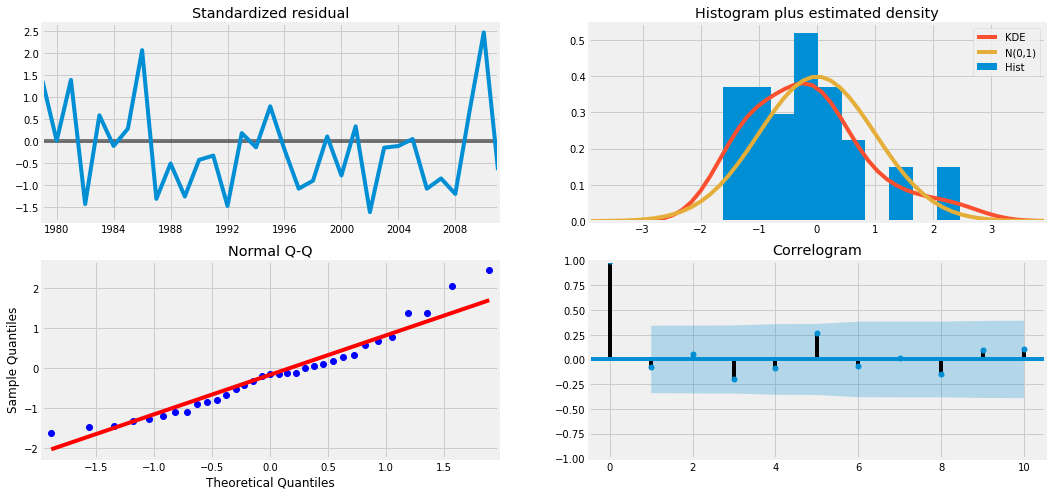

"\nOur model diagnostics suggests that the model residuals are normally distributed based on the following:\n\nIn the top right plot, we see that the red KDE line follows closely with the N(0,1) line \n(where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). \nThis is a good indication that the residuals are normally distributed.\n\nThe qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) \nfollows the linear trend of the samples taken from a standard normal distribution with N(0, 1). \nAgain, this is a strong indication that the residuals are normally distributed.\n\nThe residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. \nThis is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, \nwhich shows that the time series residuals have low correlation with lagged versions of itself.\n"

In [18]:
# model diagnostics to investigate any unusual behavior

results.plot_diagnostics(figsize=(16, 8))
plt.show()

"""
Our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line 
(where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) 
follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). 
Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. 
This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, 
which shows that the time series residuals have low correlation with lagged versions of itself.
"""

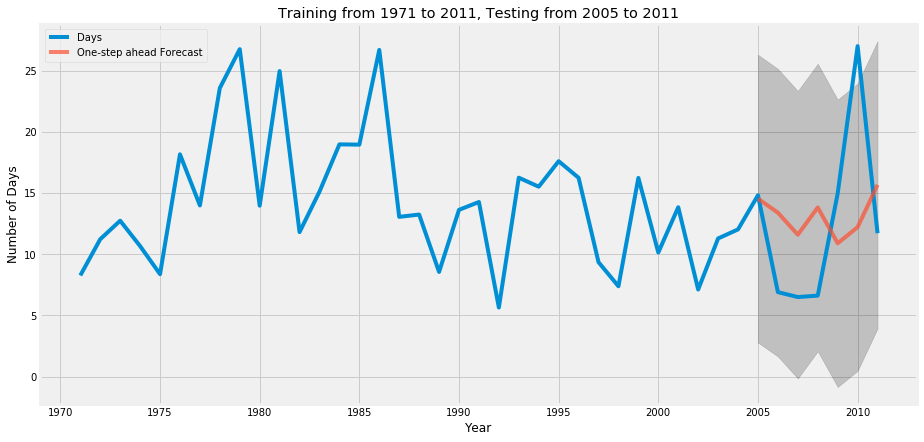

,Days
Year,
1971-01-01,8.270093
1972-01-01,11.230994
1973-01-01,12.742278
1974-01-01,10.670488
1975-01-01,8.373998
1976-01-01,18.168021
1977-01-01,13.986699
1978-01-01,23.579967
1979-01-01,26.758594


In [25]:
# validating forecasts from 2005-01-01 to the end date 2011-12-01

pred = results.get_prediction(start=pd.to_datetime('2005-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1971':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Training from 1971 to 2011, Testing from 2005 to 2011')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
df['1971':]
# observations: the predicted plot(orange) is similar to the expected plot(blue)

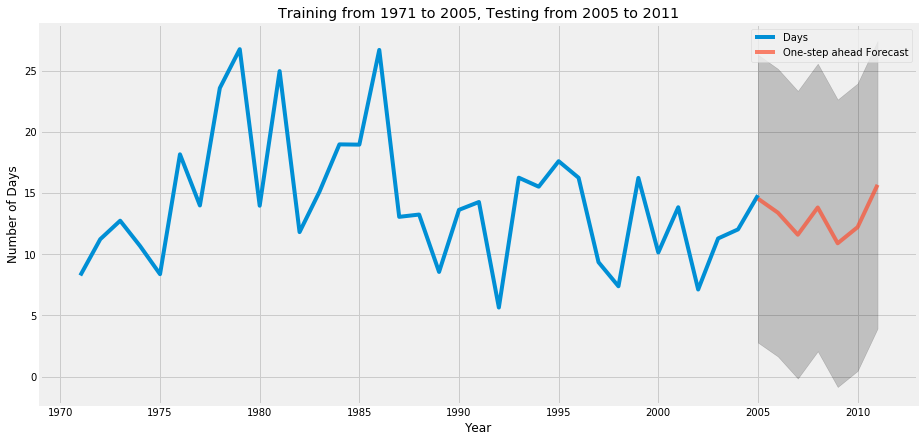

2005-01-01    14.543860
2006-01-01    13.400071
2007-01-01    11.597906
2008-01-01    13.823564
2009-01-01    10.898663
2010-01-01    12.217136
2011-01-01    15.676094
Freq: AS-JAN, dtype: float64

In [24]:
# validating forecasts from 2005-01-01 to the end date 2011-12-01

pred = results.get_prediction(start=pd.to_datetime('2005-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1971':'2005'].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Training from 1971 to 2005, Testing from 2005 to 2011')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
pred.predicted_mean
# observations: the predicted plot(orange) is similar to the expected plot(blue)

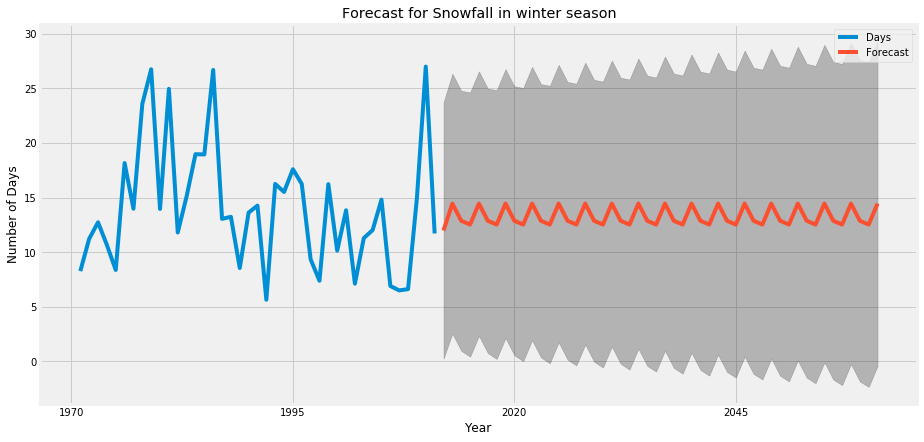

2012-01-01    11.989651
2013-01-01    14.457481
2014-01-01    12.882880
2015-01-01    12.536398
2016-01-01    14.457481
2017-01-01    12.882880
2018-01-01    12.536398
2019-01-01    14.457481
2020-01-01    12.882880
2021-01-01    12.536398
2022-01-01    14.457481
2023-01-01    12.882880
2024-01-01    12.536398
2025-01-01    14.457481
2026-01-01    12.882880
2027-01-01    12.536398
2028-01-01    14.457481
2029-01-01    12.882880
2030-01-01    12.536398
2031-01-01    14.457481
2032-01-01    12.882880
2033-01-01    12.536398
2034-01-01    14.457481
2035-01-01    12.882880
2036-01-01    12.536398
2037-01-01    14.457481
2038-01-01    12.882880
2039-01-01    12.536398
2040-01-01    14.457481
2041-01-01    12.882880
2042-01-01    12.536398
2043-01-01    14.457481
2044-01-01    12.882880
2045-01-01    12.536398
2046-01-01    14.457481
2047-01-01    12.882880
2048-01-01    12.536398
2049-01-01    14.457481
2050-01-01    12.882880
2051-01-01    12.536398
2052-01-01    14.457481
2053-01-01    12

In [26]:
# forecasting data for future 
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.title('Forecast for Snowfall in winter season')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
pred_uc.predicted_mean

In [22]:
y_forecasted = pred.predicted_mean
y_forecasted = y_forecasted.to_frame() 
y_truth = df['2005-01-01':]
y_forecasted.columns = ['Days']
y_forecasted.index.names = ['Year']

# Compute the root-mean-square
rms = np.sqrt(mean_squared_error(y_forecasted, y_truth))
print('The Root Mean Squared Error of our forecasts is:',rms)

The Root Mean Squared Error of our forecasts is: 7.279756171217336
